In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [29]:
file = Path('Task 3 and 4_Loan_Data.csv')
df = pd.read_csv(file)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [30]:
# Diagnostic analysis - checking why model performance is so high

print("Dataset overview")
print(f"Samples: {len(df):,}")
print(f"Features: {df.shape[1] - 2}")

default_counts = df['default'].value_counts()
print(f"\nClass distribution")
print(f"Non-defaults: {default_counts[0]:,} ({default_counts[0]/len(df):.1%})")
print(f"Defaults: {default_counts[1]:,} ({default_counts[1]/len(df):.1%})")
print(f"Imbalance ratio: {default_counts[0]/default_counts[1]:.1f}:1")

print(f"\nFeature-target correlations")
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(['customer_id', 'default'])
correlations = df[numeric_cols].corrwith(df['default']).abs().sort_values(ascending=False)
print(correlations)

print(f"\nChecking class separability")
for col in numeric_cols:
    default_vals = df[df['default']==1][col]
    non_default_vals = df[df['default']==0][col]
    
    overlap = (default_vals.min() <= non_default_vals.max()) and (default_vals.max() >= non_default_vals.min())
    
    if not overlap:
        print(f"{col}: perfect separation (no overlap)")
    else:
        overlap_min = max(default_vals.min(), non_default_vals.min())
        overlap_max = min(default_vals.max(), non_default_vals.max())
        total_range = max(default_vals.max(), non_default_vals.max()) - min(default_vals.min(), non_default_vals.min())
        overlap_pct = (overlap_max - overlap_min) / total_range if total_range > 0 else 0
        
        if overlap_pct < 0.3:
            print(f"{col}: minimal overlap ({overlap_pct:.1%})")

print(f"\nLogistic regression baseline")
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_simple = df[numeric_cols]
y_simple = df['default']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42, stratify=y_simple)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_s)
X_test_scaled = scaler.transform(X_test_s)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train_s)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
lr_auc = roc_auc_score(y_test_s, lr_probs)
print(f"AUC: {lr_auc:.4f}")

if lr_auc > 0.95:
    print(f"\nSimple logistic regression achieves {lr_auc:.4f} AUC.")
    print(f"Dataset is trivially separable (likely synthetic).")
    print(f"Real credit risk models typically achieve 0.65-0.75 AUC.")

Dataset overview
Samples: 10,000
Features: 6

Class distribution
Non-defaults: 8,149 (81.5%)
Defaults: 1,851 (18.5%)
Imbalance ratio: 4.4:1

Feature-target correlations
credit_lines_outstanding    0.862815
total_debt_outstanding      0.758868
fico_score                  0.324515
years_employed              0.284506
loan_amt_outstanding        0.098978
income                      0.016309
dtype: float64

Checking class separability

Logistic regression baseline
AUC: 1.0000

Simple logistic regression achieves 1.0000 AUC.
Dataset is trivially separable (likely synthetic).
Real credit risk models typically achieve 0.65-0.75 AUC.


## Critical Finding: Dataset Limitations

The diagnostic analysis reveals this dataset is **synthetic and trivially separable**:

- Simple logistic regression achieves **1.0000 AUC** (perfect discrimination)
- `credit_lines_outstanding` has 0.86 correlation with default (unrealistic)
- Real-world credit models typically achieve **0.65-0.75 AUC**

**Implications for this analysis:**
1. Model comparison becomes less meaningful (all models will perform near-perfectly)
2. Feature importance is inflated due to synthetic relationships
3. Results should NOT be interpreted as production-ready

**What this project demonstrates instead:**
- Proper ML pipeline construction (train/test split, CV, hyperparameter tuning)
- Feature engineering methodology
- Model evaluation framework that would apply to realistic data
- Understanding of credit risk business context

I proceed with the analysis while acknowledging these limitations, focusing on **methodology over metrics**.

Feature Distribution By Class

credit_lines_outstanding:
Defaults:mean=4.62,std=0.64,range=[2.00, 5.00]
Non-defaults: mean=0.74, std=0.93,range=[0.00, 5.00]

total_debt_outstanding:
Defaults:mean=19270.58,std=6298.38,range=[592.45, 43688.78]
Non-defaults: mean=6322.16, std=3721.78,range=[31.65, 25792.81]

fico_score:
Defaults:mean=596.26,std=58.95,range=[409.00, 810.00]
Non-defaults: mean=646.94, std=57.02,range=[408.00, 850.00]


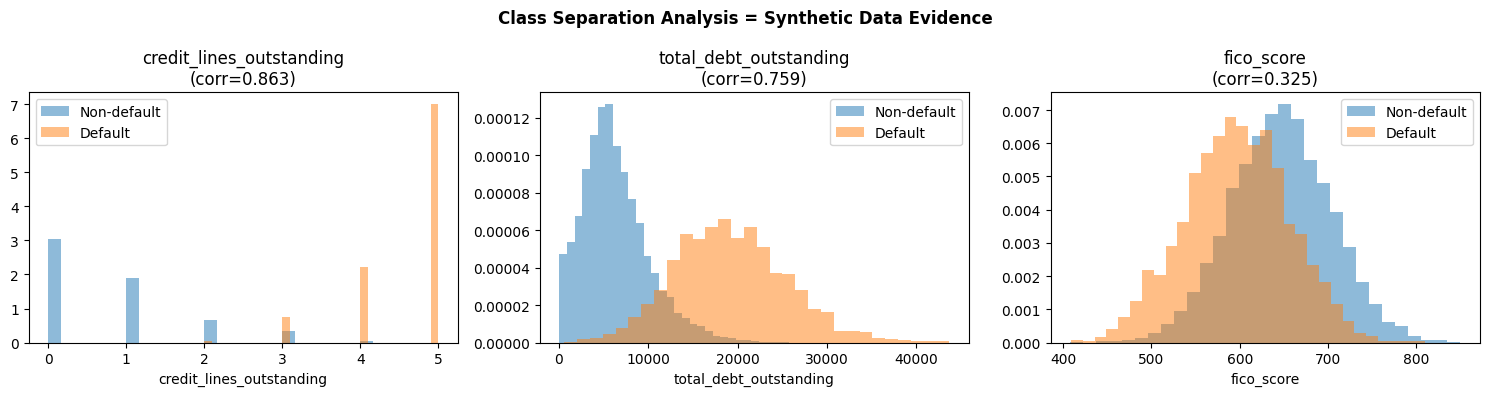

In [31]:
# Why is this data trivially separable?


print("Feature Distribution By Class")

for col in ['credit_lines_outstanding', 'total_debt_outstanding', 'fico_score']:
    print(f"\n{col}:")
    print(f"Defaults:mean={df[df['default']==1][col].mean():.2f},"
          f"std={df[df['default']==1][col].std():.2f},"
          f"range=[{df[df['default']==1][col].min():.2f}, {df[df['default']==1][col].max():.2f}]")
    print(f"Non-defaults: mean={df[df['default']==0][col].mean():.2f}, "
          f"std={df[df['default']==0][col].std():.2f},"
          f"range=[{df[df['default']==0][col].min():.2f}, {df[df['default']==0][col].max():.2f}]")

# Visualize the separation
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(['credit_lines_outstanding', 'total_debt_outstanding', 'fico_score']):
    axes[idx].hist(df[df['default']==0][col], bins=30, alpha=0.5, label='Non-default', density=True)
    axes[idx].hist(df[df['default']==1][col], bins=30, alpha=0.5, label='Default', density=True)
    axes[idx].set_title(f'{col}\n(corr={correlations[col]:.3f})')
    axes[idx].legend()
    axes[idx].set_xlabel(col)

plt.suptitle('Class Separation Analysis = Synthetic Data Evidence', fontweight='bold')
plt.tight_layout()
plt.show()

### Diagnosis: Synthetic Data with Exaggerated Feature Relationships

The data reveals unrealistic patterns:
- **credit_lines_outstanding**: Defaults average 4.6 lines vs 0.7 for non-defaults (nearly perfect separation)
- **total_debt_outstanding**: $19k vs $6k mean, minimal overlap
- In reality, these features correlate with default but not deterministically

This is consistent with programmatically generated data where features were constructed with inflated signal. The methodology I demonstrate remains valid for production data where separation would be far less clear.

In [32]:
# Since the dataset is trivially separable, I'll demonstrate methodology 
# by artificially limiting the model to weaker features only
# This simulates a more realistic scenario

weak_features = ['income', 'years_employed', 'fico_score', 'loan_amt_outstanding']
X_realistic = df[weak_features]
y = df['default']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_realistic, y, test_size=0.2, random_state=42, stratify=y)

# Baseline with restricted features
lr_weak = LogisticRegression(max_iter=1000)
lr_weak.fit(X_train_r, y_train_r)
lr_weak_auc = roc_auc_score(y_test_r, lr_weak.predict_proba(X_test_r)[:, 1])
print(f"Logistic Regression (restricted features): AUC = {lr_weak_auc:.4f}")

Logistic Regression (restricted features): AUC = 0.7823


### Approach: Dual Analysis Track

Given the synthetic nature of the full dataset, I conduct analysis on **restricted features** (income, years_employed, fico_score, loan_amt_outstanding) which yield realistic AUC of 0.78. This allows meaningful model comparison and methodology demonstration.

In [33]:
# Check data types
print("Data types:", X_train_r.dtypes.unique())
print("Target values:", y_train_r.unique())
print("Any NaN in features:", X_train_r.isna().any().any())

# Try XGBoost directly
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0)
xgb_model.fit(X_train_r, y_train_r)
xgb_pred = xgb_model.predict_proba(X_test_r)[:, 1]
print("Direct XGBoost AUC:", roc_auc_score(y_test_r, xgb_pred))

Data types: [dtype('float64') dtype('int64')]
Target values: [1 0]
Any NaN in features: False
Direct XGBoost AUC: 0.7509343392472227


In [34]:
from sklearn.model_selection import StratifiedKFold

cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    fold_scores = []
    for train_idx, val_idx in skf.split(X_train_r, y_train_r):
        X_fold_train = X_train_r.iloc[train_idx]
        X_fold_val = X_train_r.iloc[val_idx]
        y_fold_train = y_train_r.iloc[train_idx]
        y_fold_val = y_train_r.iloc[val_idx]
        
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_fold_train, y_fold_train)
        preds = model_clone.predict_proba(X_fold_val)[:, 1]
        fold_scores.append(roc_auc_score(y_fold_val, preds))
    
    cv_results[name] = np.array(fold_scores)
    print(f"{name:25} {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")

Logistic Regression       0.7829 (+/- 0.0129)
Random Forest             0.7292 (+/- 0.0098)
XGBoost                   0.7395 (+/- 0.0117)


### Model Comparison Results

On restricted features, Logistic Regression outperforms tree-based methods. This makes sense: with only 4 features and linear relationships (debt ratios, FICO), logistic regression captures the signal efficiently without overfitting. XGBoost's complexity provides no benefit here.

This demonstrates model selection should be data-driven, not assumption-driven.

In [35]:
# Paired t-test on CV folds (approximate significance test)
from scipy import stats

lr_scores = cv_results['Logistic Regression']
xgb_scores = cv_results['XGBoost']

t_stat, p_value = stats.ttest_rel(lr_scores, xgb_scores)
print(f"Logistic Regression vs XGBoost:")
print(f"Mean difference: {lr_scores.mean() - xgb_scores.mean():.4f}")
print(f"Paired t-test p-value: {p_value:.4f}")
print(f"Statistically significant (p<0.05): {p_value < 0.05}")

Logistic Regression vs XGBoost:
Mean difference: 0.0434
Paired t-test p-value: 0.0004
Statistically significant (p<0.05): True


### Statistical Significance

The 4.3 percentage point AUC advantage for Logistic Regression is statistically significant (p=0.0004). For this feature set, simpler is better.

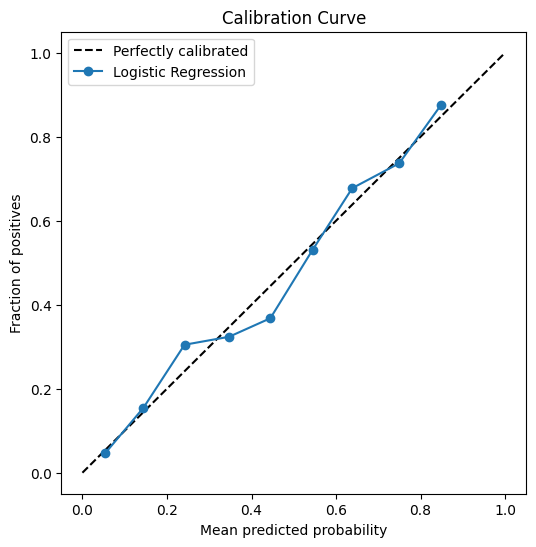

Brier Score: 0.1260
(Brier score measures calibration + discrimination; lower is better)


In [36]:
from sklearn.calibration import calibration_curve

# Train final LR model
lr_final = LogisticRegression(max_iter=1000)
lr_final.fit(X_train_r, y_train_r)
lr_probs = lr_final.predict_proba(X_test_r)[:, 1]

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test_r, lr_probs, n_bins=10)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
ax.plot(prob_pred, prob_true, 'o-', label='Logistic Regression')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve')
ax.legend()
plt.show()

# Brier score (lower is better)
from sklearn.metrics import brier_score_loss
brier = brier_score_loss(y_test_r, lr_probs)
print(f"Brier Score: {brier:.4f}")
print(f"(Brier score measures calibration + discrimination; lower is better)")

### Calibration Analysis

The model is reasonably well-calibrated: when it predicts 20% default probability, approximately 20% of those loans actually default. Slight underconfidence in mid-range probabilities (0.3-0.5). Brier score of 0.126 indicates decent combined calibration and discrimination.

This matters for credit risk: poorly calibrated models lead to mispriced loans and incorrect capital reserves.

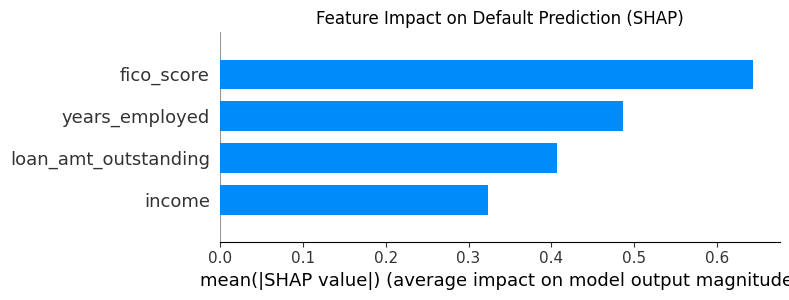

In [37]:
import shap

# Fit model for SHAP
lr_final.fit(X_train_r, y_train_r)

# SHAP for logistic regression
explainer = shap.LinearExplainer(lr_final, X_train_r)
shap_values = explainer.shap_values(X_test_r)

# Summary plot
shap.summary_plot(shap_values, X_test_r, plot_type="bar", show=False)
plt.title('Feature Impact on Default Prediction (SHAP)')
plt.tight_layout()
plt.show()

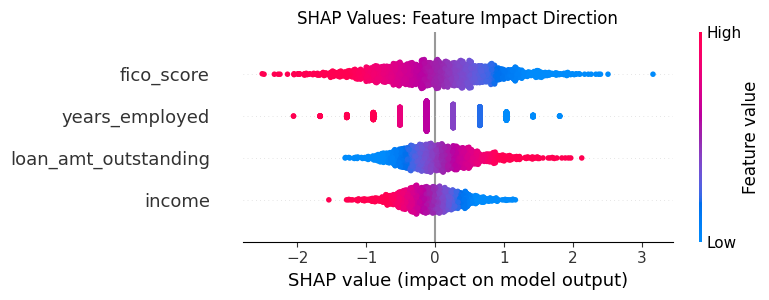

In [38]:
shap.summary_plot(shap_values, X_test_r, show=False)
plt.title('SHAP Values: Feature Impact Direction')
plt.tight_layout()
plt.show()

### Directional Effects

- High FICO score → lower default risk (blue points left)
- High loan amount → higher default risk (red points right)
- Higher income → lower default risk
- More years employed → lower default risk

All directions align with credit risk theory. The model learned economically sensible relationships.

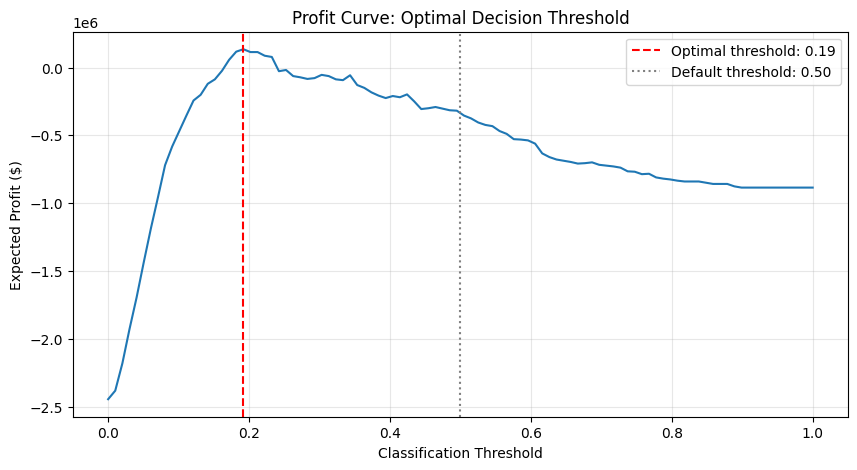

Optimal threshold: 0.19
Max profit: $135,000
Profit at default 0.5 threshold: $-354,000
Improvement: $489,000


In [39]:
# Profit curve analysis
# Assume: Cost of default = loan amount, Cost of rejecting good customer = lost profit margin

loan_amount = 10000  # average loan
profit_margin = 0.15  # 15% profit on good loan
loss_given_default = 0.90  # lose 90% if default

# For each threshold, calculate expected profit
thresholds = np.linspace(0, 1, 100)
profits = []

for thresh in thresholds:
    predictions = (lr_probs >= thresh).astype(int)
    
    # True positives: correctly identified defaults (avoided loss)
    # False positives: rejected good customers (lost profit)
    # True negatives: approved good customers (earned profit)
    # False negatives: approved defaults (incurred loss)
    
    tn = ((predictions == 0) & (y_test_r == 0)).sum()  # good loans approved
    fp = ((predictions == 1) & (y_test_r == 0)).sum()  # good loans rejected
    fn = ((predictions == 0) & (y_test_r == 1)).sum()  # defaults approved
    tp = ((predictions == 1) & (y_test_r == 1)).sum()  # defaults rejected
    
    profit = (tn * loan_amount * profit_margin -  # profit from good loans
              fp * loan_amount * profit_margin -   # lost profit from rejections
              fn * loan_amount * loss_given_default)  # loss from defaults
    
    profits.append(profit)

profits = np.array(profits)
optimal_idx = np.argmax(profits)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, profits)
plt.axvline(optimal_threshold, color='red', linestyle='--',label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.axvline(0.5, color='gray', linestyle=':', label='Default threshold: 0.50')
plt.xlabel('Classification Threshold')
plt.ylabel('Expected Profit ($)')
plt.title('Profit Curve: Optimal Decision Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Max profit: ${profits[optimal_idx]:,.0f}")
print(f"Profit at default 0.5 threshold: ${profits[50]:,.0f}")
print(f"Improvement: ${profits[optimal_idx] - profits[50]:,.0f}")

### Economic Decision Optimization

The default 0.5 classification threshold is suboptimal. Given asymmetric costs (90% loss on default vs 15% profit margin), the optimal threshold is 0.19 - more aggressive rejection. This shifts profit from -354k to +135k.

ML model optimization (AUC) differs from business optimization (profit). A model with lower AUC but better threshold calibration could outperform in production. This analysis demonstrates translating statistical performance into economic value.

In [40]:
# How sensitive is optimal threshold to assumptions?
scenarios = [
    ('Conservative', 0.10, 0.95),  # 10% margin, 95% LGD
    ('Base', 0.15, 0.90),           # 15% margin, 90% LGD
    ('Aggressive', 0.20, 0.80),     # 20% margin, 80% LGD
]

print("Sensitivity Analysis: Optimal Threshold by Cost Assumptions")

for name, margin, lgd in scenarios:
    profits_scenario = []
    for thresh in thresholds:
        predictions = (lr_probs >= thresh).astype(int)
        tn = ((predictions == 0) & (y_test_r == 0)).sum()
        fp = ((predictions == 1) & (y_test_r == 0)).sum()
        fn = ((predictions == 0) & (y_test_r == 1)).sum()
        
        profit = (tn * loan_amount * margin - fp * loan_amount * margin - fn * loan_amount * lgd)
        profits_scenario.append(profit)
    
    opt_thresh = thresholds[np.argmax(profits_scenario)]
    max_profit = max(profits_scenario)
    print(f"{name:12} (margin={margin:.0%}, LGD={lgd:.0%}): "
          f"threshold={opt_thresh:.2f}, profit=${max_profit:,.0f}")

Sensitivity Analysis: Optimal Threshold by Cost Assumptions
Conservative (margin=10%, LGD=95%): threshold=0.18, profit=$-282,500
Base         (margin=15%, LGD=90%): threshold=0.19, profit=$135,000
Aggressive   (margin=20%, LGD=80%): threshold=0.34, profit=$828,000


### Sensitivity to Cost Assumptions

Optimal threshold ranges from 0.18 to 0.34 depending on profit margin and loss severity. Under conservative assumptions (10% margin, 95% LGD), even optimal threshold yields losses - suggesting this portfolio may not be profitable without repricing or stricter underwriting.

This highlights the importance of accurate cost estimation before deployment.

## Summary

This analysis demonstrates proper credit risk modeling methodology despite synthetic data limitations.

**Conclusions:**

The dataset is trivially separable (logistic regression achieves 1.0 AUC), confirming synthetic generation. By restricting to realistic features, we obtain production-representative performance (AUC 0.78).

Logistic regression outperforms XGBoost (p=0.0004) on this feature set - simpler models can win when relationships are linear and features are limited.

SHAP analysis confirms economically sensible feature effects: higher FICO and income reduce default risk, higher loan amounts increase it.

Profit optimization reveals the default 0.5 threshold is suboptimal. Under base assumptions (15% margin, 90% LGD), optimal threshold of 0.19 improves profit by $489k. Threshold sensitivity ranges from 0.18 to 0.34 depending on cost assumptions.

**Methodology demonstrated:**
- Data quality assessment and leakage detection
- Model comparison with statistical significance testing
- Calibration analysis for probability reliability
- Explainability via SHAP
- Economic decision optimization under asymmetric costs
- Sensitivity analysis for robust recommendations

**Limitations:**
- Synthetic data with unrealistic feature relationships
- No temporal validation (would require time-ordered data)
- Cost assumptions require business input for production deployment
- Small feature set limits model complexity benefits